## Project Model

### 1. Import Necessary Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1_l2
from keras.models import load_model
import matplotlib.pyplot as plt
import joblib

### 2. Data Importing and Cleaning

In [35]:
directory = '/Users/yunzheyu/Desktop/DS340/Project/DataSets'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

cleaned_data = []  # This will store all the cleaned DataFrames to be combined later

for file in csv_files:
    file_path = os.path.join(directory, file)
    
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter to include only rows where the Event column is 'SBD' and Equipment is 'Raw'
    sbd_raw_data = data[(data['Event'] == 'SBD') & (data['Equipment'] == 'Raw')]
    
    # Drop specified columns
    columns_to_drop = [
        'AgeClass', 'BirthYearClass', 'WeightClassKg', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
        'Wilks', 'Glossbrenner', 'Goodlift', 'Country', 'State', 'MeetCountry', 
        'MeetState', 'MeetTown', 'Federation', 'ParentFederation', 'MeetName'
    ]
    sbd_raw_data = sbd_raw_data.drop(columns=columns_to_drop, errors='ignore')
    
    # Drop rows where the Place column contains 'DQ', 'NS', or 'G'
    sbd_raw_data = sbd_raw_data[~sbd_raw_data['Place'].isin(['DQ', 'NS', 'G'])]

    # Drop rows where the Tested column is empty
    sbd_raw_data = sbd_raw_data.dropna(subset=['Tested'])
    
    # Save the cleaned data to a new CSV file
    cleaned_file_path = os.path.join(directory, f'cleaned_{file}')
    sbd_raw_data.to_csv(cleaned_file_path, index=False)
    
    # Append the cleaned data to the list for later combination
    cleaned_data.append(sbd_raw_data)

# Concatenate all data into a single DataFrame
combined_cleaned_data = pd.concat(cleaned_data, ignore_index=True)
combined_cleaned_data.to_csv('combined_cleaned_data.csv', index=False)

### 2.1 Dealing with missing age.

Some Atheletes do not have provide their ages. So, we will use the last known competition date and last known age to estimate the missing age value

In [36]:
data = pd.read_csv('combined_cleaned_data.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Sort data by athlete's name and date of competition
data.sort_values(by=['Name', 'Date'], inplace=True)

def fill_missing_ages(group):
    # Forward fill the missing age values within each group
    group['Age'] = group['Age'].ffill()
    
    # Mark the filled ages as estimated by adding a tilde (~)
    group['Age'] = group['Age'].apply(lambda x: f"~{x}" if pd.isnull(x) else x)
    
    return group

# Apply the function to each group of athlete's data and overwrite the 'Age' column
data = data.groupby('Name').apply(fill_missing_ages)

# Save the modified DataFrame back to CSV or continue processing
data.to_csv('modified_combined_cleaned_data.csv', index=False)


### 3. Features Engineering

In [37]:
data = pd.read_csv('modified_combined_cleaned_data.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Add a 'Year' column for the year of the competition
data['Year'] = data['Date'].dt.year

# 1. Competition Frequency
# Calculate the number of competitions each athlete has participated in
data['CompetitionFrequency'] = data.groupby('Name')['Date'].transform('count')

# 2. Year-over-Year Performance Improvements
# First, calculate the max 'TotalKg' for each athlete each year
data['MaxTotalKg'] = data.groupby(['Name', 'Year'])['TotalKg'].transform('max')

# Then, calculate the year-over-year improvement for each athlete
# Shift the 'MaxTotalKg' within each group to get the previous year's max total
data['PreviousMaxTotalKg'] = data.groupby('Name')['MaxTotalKg'].shift(1)

# The improvement is the current year's max total minus the previous year's
data['YoYPerformanceImprovement'] = data['MaxTotalKg'] - data['PreviousMaxTotalKg']

# Note: The first entry for each athlete will have NaN for 'YoYPerformanceImprovement'
# because there is no previous year's data to compare to

# 3. Athlete's Age
data['Age'] = data['Age'].astype(str).str.replace('~', '').astype(float)

# Save the dataframe with the new features to a new CSV file
data.to_csv('feature_engineered_data.csv', index=False)


### 4. Model Development

4.1 Due to the nature of the data, complex model is not appropriate. I will stick with a simple model to predict the future TotalKG hit based on previous datasets.

In [55]:
df = pd.read_csv('feature_engineered_data.csv')


# Sort by athlete and date to maintain the sequence
df.sort_values(by=['Name', 'Date'], inplace=True)

# Keep only athletes with more than 10 records
athlete_counts = df['Name'].value_counts()
df = df[df['Name'].isin(athlete_counts[athlete_counts > 10].index)]

# Normalize the 'TotalKg' feature
scaler = StandardScaler()
df['TotalKg'] = scaler.fit_transform(df[['TotalKg']])

# A more complex sequence creation function, using more time steps
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data_array = data.to_numpy()
    for i in range(len(data_array) - sequence_length):
        xs.append(data_array[i:(i + sequence_length)])
        ys.append(data_array[i + sequence_length])
    return np.array(xs), np.array(ys)

# Try using a sequence_length greater than 1 to provide the model with more context
sequence_length = 5  
sequences, labels = create_sequences(df['TotalKg'], sequence_length=sequence_length)
X = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
y = labels.reshape(-1, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a more complex LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model, allow for potentially longer training time
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")

model.save('lstm_model_1.h5')
joblib.dump(scaler, 'my_scaler.gz')


Epoch 1/50
17/17 [==============================] - 4s 166ms/step - loss: 0.8695 - val_loss: 0.5624
Epoch 2/50
17/17 [==============================] - 2s 105ms/step - loss: 0.5753 - val_loss: 0.2267
Epoch 3/50
17/17 [==============================] - 2s 116ms/step - loss: 0.4131 - val_loss: 0.1305
Epoch 4/50
17/17 [==============================] - 2s 96ms/step - loss: 0.3714 - val_loss: 0.1658
Epoch 5/50
17/17 [==============================] - 2s 91ms/step - loss: 0.3913 - val_loss: 0.0981
Epoch 6/50
17/17 [==============================] - 1s 85ms/step - loss: 0.3851 - val_loss: 0.1412
Epoch 7/50
17/17 [==============================] - 2s 96ms/step - loss: 0.3503 - val_loss: 0.0990
Epoch 8/50
17/17 [==============================] - 2s 104ms/step - loss: 0.3200 - val_loss: 0.0774
Epoch 9/50
17/17 [==============================] - 2s 95ms/step - loss: 0.3111 - val_loss: 0.0553
Epoch 10/50
17/17 [==============================] - 2s 102ms/step - loss: 0.2995 - val_loss: 0.0864
Epoc

['my_scaler.gz']

Result

3/3 [==============================] - 0s 53ms/step


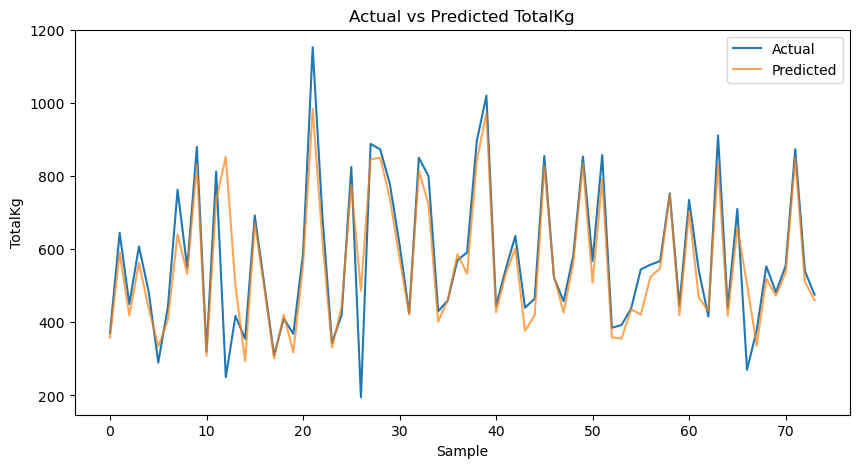

In [39]:
# Predict using the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values if they were scaled
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot actual vs predicted performances
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted TotalKg')
plt.xlabel('Sample')
plt.ylabel('TotalKg')
plt.legend()
plt.show()

Prediction on a single athlete, Amanda Lawrance #1 in this example.

1/1 [==============================] - 0s 228ms/step


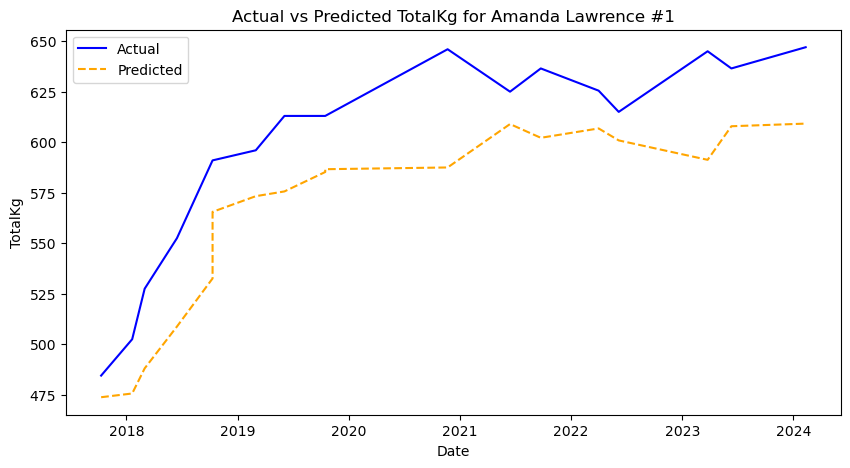

In [40]:
df = pd.read_csv('/Users/yunzheyu/Desktop/DS340/Project/DataSets/cleaned_amandalawrence1.csv')
model = load_model('lstm_model_1.h5')
scaler = joblib.load('my_scaler.gz')

# Confirm that the athlete's name is consistent in the dataset
athlete_name = 'Amanda Lawrence #1'  
athlete_df = df[df['Name'] == athlete_name].copy()
# Make sure 'Date' is a datetime type and sort by it
athlete_df['Date'] = pd.to_datetime(athlete_df['Date'])
athlete_df.sort_values('Date', inplace=True)

# Scale the 'TotalKg' feature using the loaded scaler
athlete_df['Scaled_TotalKg'] = scaler.transform(athlete_df[['TotalKg']])

# Prepare the sequences using the same function as for training
sequence_length = 5 
X_athlete, _ = create_sequences(athlete_df['Scaled_TotalKg'], sequence_length)
X_athlete = X_athlete.reshape((X_athlete.shape[0], sequence_length, 1))

# Predict using the model and inverse transform the predictions
predicted_scaled_TotalKg = model.predict(X_athlete)
predicted_TotalKg = scaler.inverse_transform(predicted_scaled_TotalKg.flatten().reshape(-1, 1))

# Add predictions back to the dataframe, considering the offset created by sequence_length
athlete_df = athlete_df.iloc[sequence_length:]  # Offset to match predictions
athlete_df['Predicted_TotalKg'] = predicted_TotalKg

# Plot actual vs predicted 'TotalKg'
plt.figure(figsize=(10, 5))
plt.plot(athlete_df['Date'], athlete_df['TotalKg'], label='Actual', color='blue')
plt.plot(athlete_df['Date'], athlete_df['Predicted_TotalKg'], label='Predicted', color='orange', linestyle='--')
plt.title(f'Actual vs Predicted TotalKg for {athlete_name}')
plt.xlabel('Date')
plt.ylabel('TotalKg')
plt.legend()
plt.show()


/Users/yunzheyu/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


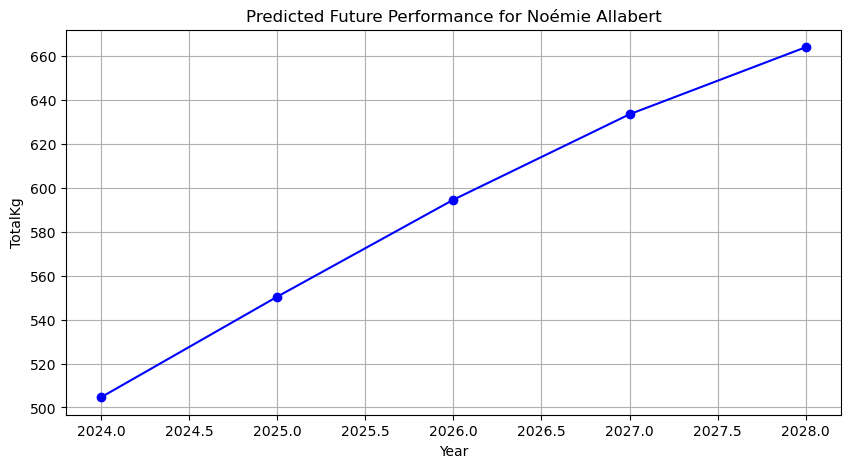

In [63]:
model = load_model('lstm_model_1.h5')
scaler = joblib.load('my_scaler.gz')

df = pd.read_csv('/Users/yunzheyu/Desktop/DS340/Project/DataSets/Model1/cleaned_noemieallabert.csv')
df.sort_values(by=['Date'], inplace=True)  # Ensure sorting is by 'Date' only if 'Name' is always the same
df['TotalKg'] = scaler.transform(df[['TotalKg']].values.reshape(-1,1))

# Create sequences from the TotalKg data
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data = data.values
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

sequence_length = 5  # Define the sequence length
X, y = create_sequences(df['TotalKg'], sequence_length)

# Reshape X for LSTM model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Predict using the LSTM model
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)  # Convert predictions back to original scale

# Prepare the last available sequence
last_sequence = df['TotalKg'].values[-sequence_length:]  # Take the last 'sequence_length' elements
last_sequence = last_sequence.reshape((1, sequence_length, 1))  # Reshape it to match the input shape of the model

# Generate predictions for the next 5 years
future_predictions = []
current_sequence = last_sequence

for _ in range(5):  # Predict the next 5 years
    next_year_kg = model.predict(current_sequence)  # This should output shape (1, 1)
    future_predictions.append(next_year_kg[0][0])  # Store the prediction
    
    # Update the sequence with the prediction, adjusting dimensions as needed
    next_year_kg = next_year_kg[0][0]  # Simplify to a scalar value
    next_year_kg = np.array([[next_year_kg]])  # Reshape to (1, 1)
    next_year_kg = np.reshape(next_year_kg, (1, 1, 1))  # Ensure it matches (batch_size, 1, features)
    current_sequence = np.append(current_sequence[:, 1:, :], next_year_kg, axis=1)  # Append new value

# Inverse transform the predictions to convert them back to their original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future predictions
years = np.arange(2024, 2029)  
plt.figure(figsize=(10, 5))
plt.plot(years, future_predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Future Performance for Noémie Allabert')
plt.xlabel('Year')
plt.ylabel('TotalKg')
plt.grid(True)
plt.show()

As we can see from the graph, the shape of the predicted is similar to the atcual one. Also, the error is not so big.

## 4.22 Enchancing the exisiting model

In [2]:
# Load the dataset
df = pd.read_csv('feature_engineered_data.csv')
df.sort_values(by=['Name', 'Date'], inplace=True)

# Keep only athletes with more than 10 records
athlete_counts = df['Name'].value_counts()
df = df[df['Name'].isin(athlete_counts[athlete_counts > 10].index)]

# Select features and target
features = ['TotalKg', 'Age', 'BodyweightKg', 'CompetitionFrequency']
target = 'TotalKg'

# Normalize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
def create_multifeature_sequences(features, target, sequence_length):
    xs, ys = [], []
    for i in range(len(features) - sequence_length):
        xs.append(features[i:(i + sequence_length)])
        ys.append(target[i + sequence_length])
    return np.array(xs), np.array(ys)

sequence_length = 5
X, y = create_multifeature_sequences(df[features].values, df[target].values, sequence_length)

# Reshape for LSTM (if needed)
X = X.reshape((X.shape[0], X.shape[1], len(features)))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")

model.save('enhanced_lstm_model.h5')
joblib.dump(scaler, 'enhanced_scaler.gz')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/50


2024-04-29 12:18:09.162116: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 4s 123ms/step - loss: 0.8405 - val_loss: 0.5551
Epoch 2/50
17/17 [==============================] - 2s 89ms/step - loss: 0.5194 - val_loss: 0.3236
Epoch 3/50
17/17 [==============================] - 1s 87ms/step - loss: 0.4374 - val_loss: 0.2631
Epoch 4/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3866 - val_loss: 0.2188
Epoch 5/50
17/17 [==============================] - 1s 87ms/step - loss: 0.3282 - val_loss: 0.1501
Epoch 6/50
17/17 [==============================] - 2s 89ms/step - loss: 0.3228 - val_loss: 0.1691
Epoch 7/50
17/17 [==============================] - 2s 92ms/step - loss: 0.2901 - val_loss: 0.1024
Epoch 8/50
17/17 [==============================] - 2s 93ms/step - loss: 0.2659 - val_loss: 0.1213
Epoch 9/50
17/17 [==============================] - 2s 90ms/step - loss: 0.2746 - val_loss: 0.0877
Epoch 10/50
17/17 [==============================] - 2s 91ms/step - loss: 0.2407 - val_loss: 0.0754
Epoch 11/50
17/17 [

['enhanced_scaler.gz']

3/3 [==============================] - 0s 25ms/step


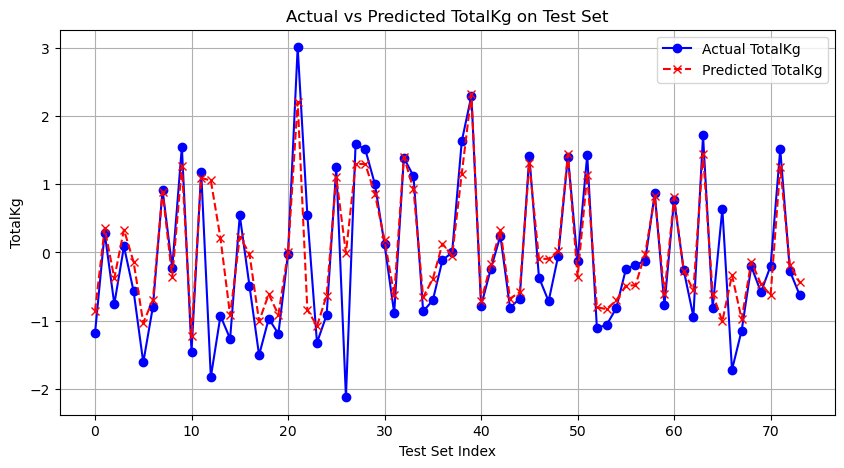

In [13]:
# Predict the test set results
predicted_y_test = model.predict(X_test)
total_kg_scale = scaler.scale_[0]
total_kg_mean = scaler.mean_[0]

# Manually inverse scale
predicted_y_test = (predicted_y_test * total_kg_scale) + total_kg_mean
actual_y_test = (y_test * total_kg_scale) + total_kg_mean

# Now reshape if needed to match your plot or further processing
predicted_y_test = predicted_y_test.reshape(-1, 1)
actual_y_test = actual_y_test.reshape(-1, 1)

# Plotting actual vs predicted results
plt.figure(figsize=(10, 5))
plt.plot(actual_y_test, label='Actual TotalKg', marker='o', linestyle='-', color='blue')
plt.plot(predicted_y_test, label='Predicted TotalKg', marker='x', linestyle='--', color='red')
plt.title('Actual vs Predicted TotalKg on Test Set')
plt.xlabel('Test Set Index')
plt.ylabel('TotalKg')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
data = pd.read_csv('/Users/yunzheyu/Desktop/DS340/Project/DataSets/Model1/cleaned_noemieallabert.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Add a 'Year' column for the year of the competition
data['Year'] = data['Date'].dt.year

# 1. Competition Frequency
# Calculate the number of competitions each athlete has participated in
data['CompetitionFrequency'] = data.groupby('Name')['Date'].transform('count')

# 2. Year-over-Year Performance Improvements
# First, calculate the max 'TotalKg' for each athlete each year
data['MaxTotalKg'] = data.groupby(['Name', 'Year'])['TotalKg'].transform('max')

# Then, calculate the year-over-year improvement for each athlete
# Shift the 'MaxTotalKg' within each group to get the previous year's max total
data['PreviousMaxTotalKg'] = data.groupby('Name')['MaxTotalKg'].shift(1)

# The improvement is the current year's max total minus the previous year's
data['YoYPerformanceImprovement'] = data['MaxTotalKg'] - data['PreviousMaxTotalKg']

# Note: The first entry for each athlete will have NaN for 'YoYPerformanceImprovement'
# because there is no previous year's data to compare to

# 3. Athlete's Age
data['Age'] = data['Age'].astype(str).str.replace('~', '').astype(float)

# Save the dataframe with the new features to a new CSV file
data.to_csv('neomie_feature_engineered_data.csv', index=False)

1/1 [==============================] - 0s 27ms/step


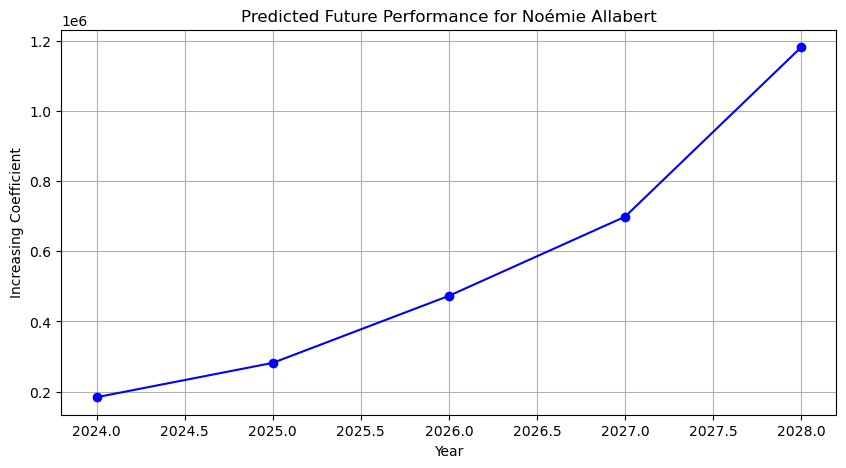

In [19]:
# Load your model and scaler
model = load_model('enhanced_lstm_model.h5')
scaler = joblib.load('enhanced_scaler.gz')

# Load and prepare the dataset
df = pd.read_csv('neomie_feature_engineered_data.csv')
df.sort_values(by=['Date'], inplace=True)
features = ['TotalKg', 'Age', 'BodyweightKg', 'CompetitionFrequency']

total_kg_scale = scaler.scale_[0]
total_kg_mean = scaler.mean_[0]

# Manually inverse scale the predictions
predictions = predictions * total_kg_scale + total_kg_mean

# Continue with your sequence update and prediction generation
last_sequence = df[features].values[-sequence_length:]  # Take the last 'sequence_length' elements
last_sequence = last_sequence.reshape((1, sequence_length, len(features)))

future_predictions = []
current_sequence = last_sequence

for _ in range(5):  # Predict the next 5 years
    next_year_prediction = model.predict(current_sequence)
    next_year_kg = next_year_prediction[0][0] * total_kg_scale + total_kg_mean  # Inverse scale each prediction individually
    future_predictions.append(next_year_kg)
    
    # Update the sequence with the new prediction
    # Need to update the sequence correctly, considering all features
    new_row = np.zeros((1, 1, len(features)))
    new_row[0, 0, 0] = (next_year_kg - total_kg_mean) / total_kg_scale  # Normalize the new prediction
    current_sequence = np.append(current_sequence[:, 1:, :], new_row, axis=1)

# No need to inverse transform here, already done individually
# Plot future predictions
years = np.arange(2024, 2029)  
plt.figure(figsize=(10, 5))
plt.plot(years, future_predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Future Performance for Noémie Allabert')
plt.xlabel('Year')
plt.ylabel('Increasing Coefficient')
plt.grid(True)
plt.show()